# Bigrama


## Análisis del conjunto de datos


In [1]:
words = open('prenoms.txt', 'r').read().splitlines()
print('Les 5 prénoms les plus populaires : ',words[:5])
print('Les 5 prénoms les moins populaires : ',words[-5:])
print('Le prénom le plus long : ',max(words, key=len))
print('Le prénom le plus court : ',min(words, key=len))


Les 5 prénoms les plus populaires :  ['MARIE', 'JEAN', 'PIERRE', 'MICHEL', 'ANDRÉ']
Les 5 prénoms les moins populaires :  ['ÉLOUEN', 'CHEYNA', 'BLONDIE', 'IMANN', 'GHILAIN']
Le prénom le plus long :  GUILLAUME-ALEXANDRE
Le prénom le plus court :  GUY


In [2]:
unique_characters = set()
for word in words:
  # Ajouter chaque caractère de la ligne à l'ensemble des caractères uniques
  for char in word.strip():
    unique_characters.add(char)
print('Nombre de caractères uniques : ',len(unique_characters))
print('Caractères uniques : ',unique_characters)

Nombre de caractères uniques :  45
Caractères uniques :  {'Ï', 'Ü', 'Ÿ', 'U', 'Ô', 'S', 'Æ', 'À', 'È', '-', 'W', 'H', 'Ê', 'É', 'R', 'M', 'E', 'Ë', 'N', 'Î', 'X', 'Ä', 'F', 'Â', 'K', 'D', 'Ö', 'I', 'J', 'Y', 'A', 'C', 'O', 'Û', 'Ù', 'B', 'Z', 'P', 'T', "'", 'Q', 'Ç', 'G', 'L', 'V'}


## ¿Qué es un bigrama?


Recordemos que el objetivo del proyecto es predecir el siguiente carácter a partir de los caracteres anteriores. En el modelo de **bigramas**, nos basamos únicamente en el carácter anterior para predecir el carácter actual. Es la versión más simple de este tipo de modelo.


Claro, para predecir un nombre, debemos empezar desde cero. Para predecir la primera letra, necesitamos conocer la probabilidad de que una letra sea la primera (y lo mismo para la última letra). Por lo tanto, añadimos un carácter especial '.' al inicio y al final de cada palabra antes de construir nuestros bigramas.


En cada nombre, tenemos varios ejemplos de bigramas (cada uno es independiente).
Tomemos el primer nombre y veamos cuántos bigramas contiene:


In [3]:
chs = ['.'] + list(words[0]) + ['.']
for ch1, ch2 in zip(chs, chs[1:]):
  bigram = (ch1, ch2)
  print(bigram)

('.', 'M')
('M', 'A')
('A', 'R')
('R', 'I')
('I', 'E')
('E', '.')


El nombre "Marie" contiene 6 bigramas.


## Método por conteo


Construyamos ahora un diccionario en Python que agrupe todos los bigramas del conjunto de datos contando sus ocurrencias.


In [4]:
b = {}
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    bigram = (ch1, ch2)
    b[bigram] = b.get(bigram, 0) + 1
sorted(b.items(), key = lambda kv: -kv[1])
print('Les 5 bigrammes les plus fréquents : ',sorted(b.items(), key = lambda kv: -kv[1])[:5])

Les 5 bigrammes les plus fréquents :  [(('A', '.'), 7537), (('E', '.'), 6840), (('A', 'N'), 6292), (('N', '.'), 3741), (('N', 'E'), 3741)]


Ahora tenemos nuestro diccionario de frecuencias de bigramas en todo el conjunto de datos. Como podemos ver, es frecuente que los nombres terminen en A, E o N, y que las letras A y N se sucedan, así como las letras N y E.


### Matriz de ocurrencias


Es más sencillo visualizar y procesar los datos en forma de matriz. Vamos a construir una matriz de tamaño 46x46 (45 caracteres + el carácter especial '.') donde la fila corresponde a la primera letra y la columna a la segunda.


In [5]:
import torch
N = torch.zeros((46, 46), dtype=torch.int32)

Vamos a ordenar nuestros caracteres y crear tablas de búsqueda (look-up tables) con el objeto diccionario de Python. Queremos poder convertir un carácter a un entero (para indexar en la matriz) y viceversa (para reconstruir los nombres a partir de enteros).


In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

Vamos a llenar ahora nuestra matriz:


In [7]:
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    N[ix1, ix2] += 1

Ahora podemos mostrar la matriz (tabla de búsqueda).


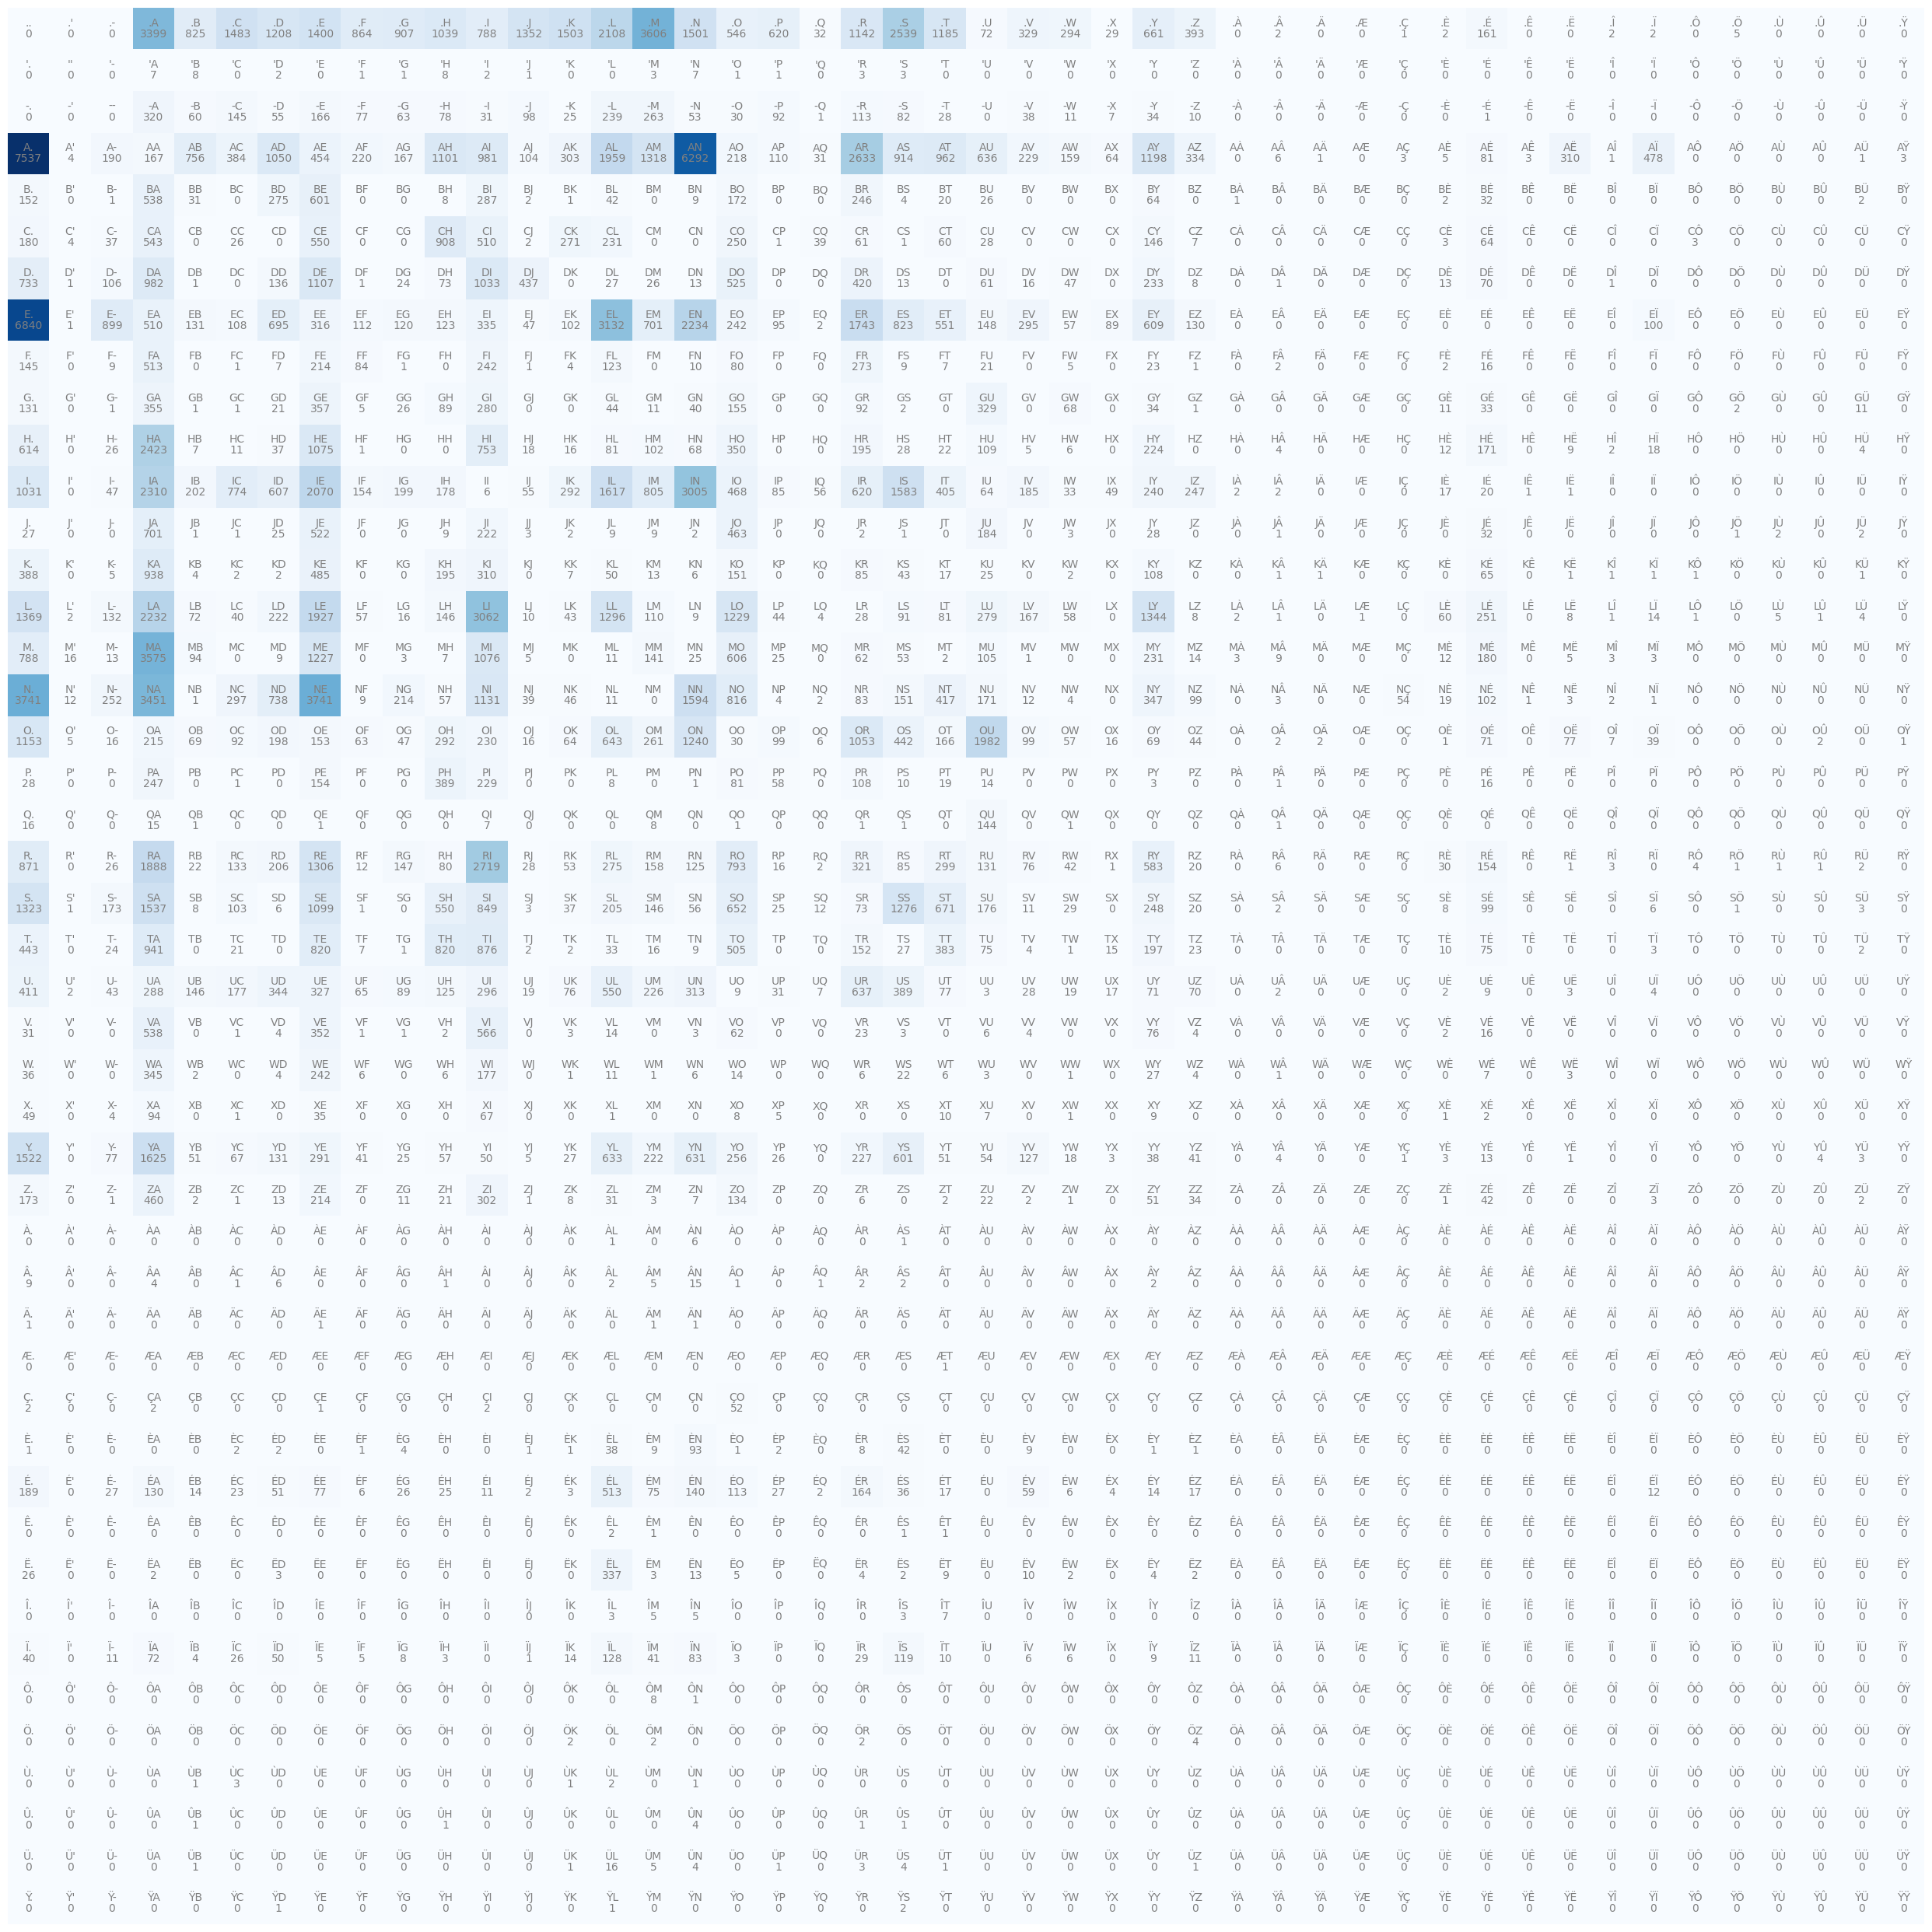

In [10]:
#Code pour dessiner une jolie matrice
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(32,32))
plt.imshow(N, cmap='Blues')
for i in range(46):
  for j in range(46):
    chstr = itos[i] + itos[j]
    plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
    plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

### Probabilidades


Para conocer la probabilidad de que un nombre comience con una letra específica, debemos observar la fila del carácter '.', es decir, la fila 0, y normalizar cada valor dividiéndolo por la suma de los valores de esa fila (para obtener valores entre 0 y 1 cuya suma sea igual a 1).


In [15]:
p = N[0].float()
p = p / p.sum()
print("Compte de la première ligne : ",N[0])
print("Probabilités : ",p)

Compte de la première ligne :  tensor([   0,    0,    0, 3399,  825, 1483, 1208, 1400,  864,  907, 1039,  788,
        1352, 1503, 2108, 3606, 1501,  546,  620,   32, 1142, 2539, 1185,   72,
         329,  294,   29,  661,  393,    0,    2,    0,    0,    1,    2,  161,
           0,    0,    2,    2,    0,    5,    0,    0,    0,    0],
       dtype=torch.int32)
Probabilités :  tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 1.1330e-01, 2.7500e-02, 4.9433e-02,
        4.0267e-02, 4.6667e-02, 2.8800e-02, 3.0233e-02, 3.4633e-02, 2.6267e-02,
        4.5067e-02, 5.0100e-02, 7.0267e-02, 1.2020e-01, 5.0033e-02, 1.8200e-02,
        2.0667e-02, 1.0667e-03, 3.8067e-02, 8.4633e-02, 3.9500e-02, 2.4000e-03,
        1.0967e-02, 9.8000e-03, 9.6667e-04, 2.2033e-02, 1.3100e-02, 0.0000e+00,
        6.6667e-05, 0.0000e+00, 0.0000e+00, 3.3333e-05, 6.6667e-05, 5.3667e-03,
        0.0000e+00, 0.0000e+00, 6.6667e-05, 6.6667e-05, 0.0000e+00, 1.6667e-04,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])


Para generar nombres de manera aleatoria, no siempre queremos elegir la letra más probable (ya que siempre generaríamos el mismo nombre). Queremos elegir una letra en función de su probabilidad. Si la letra 'n' tiene una probabilidad de 0.1, queremos elegirla el 10% de las veces.
Para esto, utilizamos la función `torch.multinomial` de PyTorch.


In [16]:
ix = torch.multinomial(p, num_samples=1, replacement=True).item()
itos[ix]

'Z'

En cada llamada, obtenemos una letra diferente en función de su probabilidad de aparición en nuestro conjunto de datos de prueba.


Con todos estos elementos, ahora estamos listos para generar nombres a partir de nuestra matriz N. Lo ideal sería crear una matriz con las probabilidades directamente para evitar tener que renormalizar cada vez.


In [17]:
# On copie N et on la convertit en float
P = N.float()
# On normalise chaque ligne
# On somme sur la première dimension (les colonnes)
print("Somme des lignes : ",P.sum(1, keepdims=True).shape)
P /= P.sum(1, keepdims=True) # /= est un raccourci pour P = P / P.sum(1, keepdims=True)
print("Matrice normalisée P est de taille : ",P.shape)
# On vérifie que la somme d'une ligne est égale à 1
print("Somme de la première ligne de P : ",P.sum(1)[0].item())

Somme des lignes :  torch.Size([46, 1])
Matrice normalisée P est de taille :  torch.Size([46, 46])
Somme de la première ligne de P :  1.0


**Nota sobre la división de matrices de diferentes tamaños**: Como habrán notado, dividimos una matriz de tamaño (46,46) por una matriz de tamaño (46,1), lo cual parece imposible. Con PyTorch, existen [reglas de broadcasting](https://pytorch.org/docs/stable/notes/broadcasting.html). Les recomiendo encarecidamente familiarizarse con este concepto, ya que es una fuente frecuente de errores. Para entender en detalle las reglas de broadcasting, pueden consultar el [curso adicional](../Bonus_CoursSpécifiques/04_Broadcasting.ipynb).
En la práctica, al dividir una matriz de tamaño (46,46) por una matriz de tamaño (46,1), se "broadcastea" la matriz (46,1) a (46,46) copiando 46 veces la matriz base. Esto permite realizar la operación como se desea.


### Generación


¡Por fin es hora de generar nombres con nuestro método de bigramas!
Vamos a definir una función para generar nombres:


In [18]:
def genName():
  out = []
  ix = 0 # On commence par '.'
  while True: # Tant qu'on n'a pas généré le caractère '.'
    p = P[ix] # On récupère la distribution de probabilité de la ligne correspondant au caractère actuel
    ix = torch.multinomial(p, num_samples=1, replacement=True).item() # On tire un échantillon
    out.append(itos[ix]) # On ajoute le caractère à notre prénom
    if ix == 0:
      break
  return ''.join(out)
genName()

'MARAUSUR.'

Por ejemplo, podemos generar 10 nombres aleatorios:


In [19]:
for i in range(10):
  print(genName())

DA.
TYEYSE-SSCL.
DE.
ANINEDANDVI.
SOKE.
RENNA.
FUXA.
EROA.
FA.
KALEN.


Como pueden ver, la generación es bastante mala...
¿Por qué? Porque el bigrama es un método muy limitado. Basarse únicamente en el último carácter no permite tener suficiente conocimiento para generar nombres correctos.


## Evaluación del modelo


### Máxima verosimilitud o likelihood


Ahora queremos evaluar nuestro modelo en el conjunto de entrenamiento. Para esto, usamos la máxima verosimilitud, como en [el segundo notebook del curso 1](../01_Fondations/02_RégressionLogistique.ipynb).
La máxima verosimilitud o *likelihood* es una medida que corresponde al producto de las probabilidades de los eventos. Para tener un buen modelo, buscamos maximizar el *likelihood*.


In [20]:
productOfProbs = 1
for w in words[:2]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    productOfProbs *= prob
    print(f"La probabilité de {ch1}->{ch2} est {prob.item():.3f}")
print("Le produit des probabilités est : ",productOfProbs.item())

La probabilité de .->M est 0.120
La probabilité de M->A est 0.431
La probabilité de A->R est 0.084
La probabilité de R->I est 0.256
La probabilité de I->E est 0.119
La probabilité de E->. est 0.321
La probabilité de .->J est 0.045
La probabilité de J->E est 0.232
La probabilité de E->A est 0.024
La probabilité de A->N est 0.201
La probabilité de N->. est 0.212
Le produit des probabilités est :  4.520583629652464e-10


Vemos rápidamente que multiplicar las probabilidades plantea un problema. Aquí, las multiplicamos sobre 2 de los 30,000 elementos del conjunto de datos y obtenemos un valor muy bajo. Si las multiplicamos sobre todo el conjunto de datos, obtenemos un valor que no puede ser representado por una computadora.


### Log-likelihood


Para resolver este problema de precisión, usamos el logaritmo por varias razones:

- La función log es monótona, es decir, si $a > b$, entonces $log(a) > log(b)$. Maximizar el *log-likelihood* es equivalente a maximizar el *likelihood* en un contexto de optimización.

- Una propiedad interesante de los logaritmos (que explica por qué esta función se usa a menudo en optimización y probabilidad) es la siguiente regla: $log(a \times b) = log(a) + log(b)$. Esto nos permite evitar multiplicar valores pequeños que podrían exceder la precisión de una computadora.


Por lo tanto, podemos maximizar el *log-likelihood* en lugar del *likelihood*. Retomemos el bucle anterior y veamos qué obtenemos:


In [21]:
sumOfLogs = 0
for w in words[:2]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    sumOfLogs += torch.log(prob)
print("La somme des log est : ",sumOfLogs.item())

La somme des log est :  -21.517210006713867


Obtenemos un valor mucho más razonable. Para los problemas de optimización, a menudo preferimos tener una función que minimizar. En el caso de un modelo perfecto, cada probabilidad vale 1, por lo que cada log vale 0, y la suma de los logs vale 0. De lo contrario, obtenemos valores negativos, ya que una probabilidad siempre es menor que 1 y $log(a) < 0 \text{ si } a < 1$.
Para tener un problema de minimización, usamos el *negative log-likelihood*, que corresponde simplemente al opuesto del *log-likelihood*.


A menudo, tomamos el promedio en lugar de la suma, ya que es más legible y equivalente en términos de optimización. Y lo calcularemos sobre el conjunto de nombres del conjunto de datos.


In [22]:
sumOfLogs = 0
n=0
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    sumOfLogs += - torch.log(prob)
    n+=1
print("La somme des negative log est : ",sumOfLogs.item())
print("La moyenne des negative log est : ",sumOfLogs.item()/n)

La somme des negative log est :  564925.125
La moyenne des negative log est :  2.4960792002651053


El *negative log-likelihood* del conjunto de datos es, por lo tanto, de 2.49.

También pueden ver si su nombre es común o poco común en comparación con el promedio del conjunto de datos. Para esto, solo tienen que reemplazar mi nombre "SIMON" por el suyo (en mayúsculas).


In [23]:
sumOfLogs = 0
n=0
for w in "SIMON":
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    sumOfLogs += - torch.log(prob)
    n+=1
print("La moyenne des negative log est : ",sumOfLogs.item()/n)

La moyenne des negative log est :  2.598056602478027


Si el valor del *negative log-likelihood* correspondiente a su nombre es inferior al del conjunto de datos, su nombre es bastante común. De lo contrario, es más bien poco común.


## Enfoque mediante redes neuronales


### Problema del enfoque de "conteo"


Ahora vamos a intentar resolver el mismo problema de una manera diferente. Hemos resuelto este problema simplemente contando las ocurrencias de los bigramas y calculando la probabilidad en función de esto. Este método funciona para bigramas, pero no funcionará para cosas más complejas como los N-gramas.


De hecho, nuestra tabla de búsqueda es de tamaño 46x46 para dos caracteres. Si consideramos N caracteres (por lo tanto, N-1 caracteres para predecir el N-ésimo), de inmediato tenemos muchas más posibilidades. Podemos calcular simplemente que la tabla será de tamaño $46^N$. Para N=4, esto daría una tabla de tamaño 4,477,456. Es decir, para valores de contexto importantes (los modelos actuales tienen un contexto de decenas de miles de tokens y hay más de 46 posibilidades cada vez), este enfoque no funcionará en absoluto.


Es por eso que el enfoque mediante redes neuronales es muy interesante. En la continuación del curso, mostraremos cómo resolver este mismo problema con la ayuda de una red neuronal, lo que les dará una intuición sobre las capacidades de la red cuando el contexto aumenta.


### Conjunto de datos de nuestra red neuronal


Nuestra red neuronal recibirá un carácter como entrada y deberá predecir el carácter siguiente. Como función de pérdida, podemos usar la función *negative log-likelihood* para intentar acercarnos al valor del bigrama por "conteo".


Comencemos por crear nuestro conjunto de datos de entrenamiento. Retomamos el bucle de recorrido de los bigramas de la parte anterior y, esta vez, indexamos dos listas: `xs` para las entradas y `ys` para las etiquetas.


In [18]:
# create the training set of bigrams (x,y)
xs, ys = [], []

for w in words[:1]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    print(ch1, ch2)
    xs.append(ix1)
    ys.append(ix2)
    
xs = torch.tensor(xs)
ys = torch.tensor(ys)

. M
M A
A R
R I
I E
E .


In [19]:
print("valeurs d'entrée : ",xs)
print("valeurs de sortie : ",ys)

valeurs d'entrée :  tensor([ 0, 15,  3, 20, 11,  7])
valeurs de sortie :  tensor([15,  3, 20, 11,  7,  0])


Para el valor de entrada 0, que corresponde a '.', queremos predecir una etiqueta 15, que corresponde a 'M'.


El problema de estas listas es que contienen enteros, y no es posible dar un entero como entrada a una red neuronal. En el campo del NLP, a menudo se usa el *one-hot encoding*, que consiste en convertir un índice en un vector de 0 con un 1 en la posición del índice. El tamaño del vector corresponde al número de clases posibles, por lo tanto, aquí 46.


In [20]:
import torch.nn.functional as F
# one-hot encoding
xenc = F.one_hot(xs, num_classes=46).float() # conversion en float pour le NN
print("Encodage one-hot des deux premiers caractères: ",xenc[:2])

Encodage one-hot des deux premiers caractères:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


Como pueden ver, tenemos un 1 en la posición 0 del primer vector y un 1 en la posición 15 del segundo. Estos son los vectores que servirán como entrada a nuestra red neuronal. Podemos visualizar cómo se ven estos vectores para tener una mejor intuición de lo que hace el *one-hot encoding*.


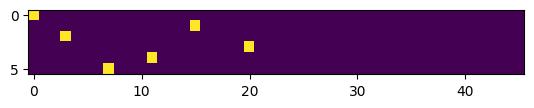

In [21]:
# Les 5 premiers vecteurs one-hot
plt.imshow(xenc)

### Nuestra red neuronal


Ahora vamos a crear nuestra red neuronal. Será una red neuronal extremadamente simple que contiene una sola capa. Para el tamaño de la capa, tomamos como entrada un vector de tamaño $n \times 46$, por lo que necesitaremos una primera dimensión de tamaño 46. En la salida, queremos una distribución de probabilidad sobre el conjunto de caracteres. Nuestra capa de red será, por lo tanto, de tamaño $46 \times 46$.


Comencemos por inicializar nuestra capa con valores aleatorios:


In [22]:
# On met le paramètre requires_grad à True pour pouvoir optimiser la matrice par descente de gradient
W = torch.randn((46, 46), requires_grad=True) 

El *forward* de nuestra red neuronal consistirá simplemente en una multiplicación matricial entre la entrada y la capa. Luego aplicaremos la función *softmax* (ver curso sobre CNN) para obtener una distribución de probabilidades.


In [23]:
# One hot encoding sur les entrées
xenc = F.one_hot(xs, num_classes=46).float() 
# Multiplication matricielle (forward pass)
logits = xenc @ W  # @ est la multiplication matricielle
#Softmax pour obtenir des probabilités
counts = logits.exp() 
probs = counts / counts.sum(1, keepdims=True) 
print(probs.shape)


torch.Size([6, 46])


Obtenemos una distribución de probabilidades para cada uno de nuestros 6 caracteres. Vamos a visualizar las salidas de nuestra red neuronal no entrenada y calcular el *negative log-likelihood* para ver dónde nos encontramos en comparación con nuestro modelo obtenido por "conteo".


In [24]:
nlls = torch.zeros(6)
for i in range(6):
  x = xs[i].item() # index de l'entrée
  y = ys[i].item() # index du label
  print('--------')
  print(f'bigramme actuel {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
  print('entrée du réseau de neurones :', x)
  print('sortie du réseau (probabilité) :', probs[i])
  print('vrai label :', y)
  p = probs[i, y]
  print('probabilité donné par le réseau sur le caractère réel :', p.item())
  logp = torch.log(p)
  nll = -logp
  print('negative log likelihood:', nll.item())
  nlls[i] = nll

print('=========')
print('negative log likelihood moyen, i.e. loss =', nlls.mean().item())

--------
bigramme actuel 1: .M (indexes 0,15)
entrée du réseau de neurones : 0
sortie du réseau (probabilité) : tensor([0.0146, 0.0210, 0.0823, 0.0077, 0.0160, 0.0483, 0.0943, 0.0204, 0.0079,
        0.0112, 0.0085, 0.0179, 0.0188, 0.0292, 0.0022, 0.0092, 0.0200, 0.0094,
        0.0097, 0.0191, 0.1091, 0.0122, 0.0092, 0.0287, 0.0120, 0.0088, 0.0053,
        0.0217, 0.0177, 0.0050, 0.0038, 0.0483, 0.0320, 0.0441, 0.0105, 0.0126,
        0.0266, 0.0092, 0.0262, 0.0081, 0.0430, 0.0012, 0.0102, 0.0025, 0.0126,
        0.0116], grad_fn=<SelectBackward0>)
vrai label : 15
probabilité donné par le réseau sur le caractère réel : 0.009214116260409355
negative log likelihood: 4.687018394470215
--------
bigramme actuel 2: MA (indexes 15,3)
entrée du réseau de neurones : 15
sortie du réseau (probabilité) : tensor([0.0574, 0.1353, 0.0227, 0.0032, 0.1142, 0.0148, 0.1007, 0.0162, 0.0242,
        0.0089, 0.0040, 0.0459, 0.0023, 0.0081, 0.0064, 0.0124, 0.0083, 0.0112,
        0.0172, 0.0062, 0.0033, 0.0

Para el cálculo de la pérdida, vamos a calcular el *negative log-likelihood* de la salida de nuestra red en relación con la etiqueta de la siguiente manera:


In [25]:
# Calcul de la loss
loss = -probs[torch.arange(6), ys].log().mean()
print(loss.item())
# On remet les gradients à zéro (None est plus efficace)
W.grad = None 
# Calcul des gradients automatique de pytorch
loss.backward()
print(W.grad)

4.670102596282959
tensor([[0.0024, 0.0035, 0.0137,  ..., 0.0004, 0.0021, 0.0019],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


Como pueden ver, hemos calculado los gradientes de nuestra matriz W con respecto a la *pérdida*. De la misma manera que en los cursos anteriores, podemos actualizar los pesos del modelo en la dirección del gradiente con un paso (el *learning_rate*).


In [26]:
# avec un learning_rate de 0.1
W.data += -0.1 * W.grad

### Optimización


A partir de todo lo que acabamos de ver, ahora podemos reunir los elementos y optimizar nuestro modelo.


**Creación del conjunto de datos completo**
Vamos a comenzar por crear nuestro conjunto de datos completo retomando el bucle anterior, pero recorriendo todo el conjunto de nombres.


In [27]:
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)


number of examples:  226325


**Inicialización del modelo**
Ahora podemos inicializar nuestro modelo como antes, elegir el *learning_rate* y el número de iteraciones.


In [28]:
W = torch.randn((46, 46), requires_grad=True)
lr=50 # en pratique, dans ce petit problème, un learning rate de 50 fonctionne bien ce qui peut sembler étonnant
iterations=100

**Descenso del gradiente**
Apliquemos ahora el algoritmo de descenso del gradiente a nuestro modelo.


In [29]:
# Descente du gradient
for k in range(iterations):
  
  # forward pass
  xenc = F.one_hot(xs, num_classes=46).float() # transformation one hot sur les entrées
  logits = xenc @ W
  probs=F.softmax(logits,dim=1) # On applique le softmax
  loss = -probs[torch.arange(num), ys].log().mean() # Calcul du negative log likelihood (loss)
  if k%10==0:
    print('loss iteration '+str(k)+' : ',loss.item())
  
  # retropropagation
  W.grad = None # Remettre la gradient à zéro à chaque itération (à ne pas oublier !!!!)
  loss.backward()
  
  # Mise à jour des poids
  W.data += -50 * W.grad

loss iteration 0 :  4.346113204956055
loss iteration 10 :  2.94492769241333
loss iteration 20 :  2.7590363025665283
loss iteration 30 :  2.6798315048217773
loss iteration 40 :  2.637108087539673
loss iteration 50 :  2.610524892807007
loss iteration 60 :  2.5923469066619873
loss iteration 70 :  2.5791807174682617
loss iteration 80 :  2.569261074066162
loss iteration 90 :  2.561541795730591


Después de 100 iteraciones, obtenemos un *negative log-likelihood* cercano al del modelo por "conteo". Esto es, de hecho, la capacidad máxima del modelo de bigramas en los datos de entrenamiento.


**Generación de nombres con nuestro modelo**
Ahora podemos generar nombres con nuestro modelo.


In [30]:
for i in range(5):
  
  out = []
  ix = 0
  while True:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=46).float()
    logits = xenc @ W 
    # Prédiction des probabilités de la lettre suivante
    p=F.softmax(logits,dim=1)
    
    # On fait un tirage aléatoire de la prochaine lettre en suivante la distribution p 
    ix = torch.multinomial(p, num_samples=1, replacement=True).item()
    # Conversion en lettre
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

JE.
S.
ADJULA.
M.
LVERTYÜCI.


### Notas adicionales


La matriz de pesos $W$ tiene el mismo tamaño que la matriz $N$ utilizada en el método de conteo. Lo que acabamos de hacer con el enfoque de red neuronal es, de hecho, aprender la matriz $N$.
Podemos confirmar esta intuición observando qué ocurre cuando realizamos la operación `xenc @ W`. Se trata de una multiplicación matricial de una matriz fila de tamaño $1 \times 46$ por una matriz cuadrada de tamaño $46 \times 46$. Además, la matriz fila contiene solo ceros, excepto un 1 en el índice $i$ de la letra. Esta multiplicación matricial da como resultado la fila $i$ de la matriz $W$.
Esto corresponde exactamente a lo que hacíamos en el método de conteo, donde recuperábamos las probabilidades de la fila $i$ de $P$.
